In [ ]:
import sys

# !{sys.executable} -m pip install numpy
import numpy as np 

# !{sys.executable} -m pip install pandas
import pandas as pd

# !{sys.executable} -m pip install nltk
import nltk

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore')

%run ./Text_Normalization_Function.ipynb

**We tested the performance under different parameters, and eventually chose to use a mix of TF-IDF and NGrams as the vectorizer, and to set max_features=50000 initially. When max_features is set to be too large, say, 100000, memory issue will easily occur. We will narrow down the scope of features in feature selection using Chi Square statistics.** 

**We chose to set the ngram_range=(2,3) because reviews written by Amazon customers contain an extremely wide range of words and phrases, so it makes more sense to not include single words, while taking into consideration of three-word phrases.**

In [2]:
from pprint import pprint
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.model_selection import KFold
from sklearn import linear_model, metrics
from sklearn.svm import SVC


#vectorizer_TF_IDF = TfidfVectorizer(max_features=100000, norm = 'l2', smooth_idf = True)
#vectorizer_Bi_Grams = CountVectorizer(max_features=100000, ngram_range=(2, 2))
#vectorizer_Tri_Grams = CountVectorizer(max_features=100000, ngram_range=(2, 3))
vectorizer_TNmix = TfidfVectorizer(max_features=50000, ngram_range=(2, 3), smooth_idf = True)

## Data Pre-processing

**Import the dataset from JSON file, convert into pandas dataframe, dump irrelevant columns, label the sentiment, normalize the "reviewText" column, and export the processed dataframe for convenience of future modifications on the following parts.**

In [123]:
import json

itemList = []
print("Started Reading JSON file: ")
with open('Luxury_Beauty_5.json') as f:
    for jsonObj in f:
        itemDict = json.loads(jsonObj)
        itemList.append(itemDict)

df_orig = pd.DataFrame(itemList) 
df_orig

Started Reading JSON file: 


,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"01 5, 2018",A2HOI48JK8838M,B00004U9V2,{'Size:': ' 0.9 oz.'},DB,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,1515110400,NaN,NaN
1,5.0,True,"04 5, 2017",A1YIPEY7HX73S7,B00004U9V2,{'Size:': ' 3.5 oz.'},Ajaey,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,1491350400,NaN,NaN
2,5.0,True,"03 27, 2017",A2QCGHIJ2TCLVP,B00004U9V2,{'Size:': ' 250 g'},D. Jones,"Best hand cream around. Silky, thick, soaks i...",Best hand cream around,1490572800,NaN,NaN
3,5.0,True,"03 20, 2017",A2R4UNHFJBA6PY,B00004U9V2,{'Size:': ' 3.5 oz.'},Amazon Customer,Thanks!!,Five Stars,1489968000,NaN,NaN
4,5.0,True,"02 28, 2017",A2QCGHIJ2TCLVP,B00004U9V2,{'Size:': ' 0.9 oz.'},D. Jones,Great hand lotion. Soaks right in and leaves ...,Great hand lotion!,1488240000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
34273,4.0,False,"09 3, 2017",A2CF66KIQ3RKX3,B01GOZ61O8,NaN,Vivian Deliz,I like to use moisturizers and sunscreens that...,Works great as a moisturizer and sunscreen,1504396800,NaN,NaN
34274,4.0,False,"09 3, 2017",A1LKOIZXPQ9VG0,B01GOZ61O8,NaN,Elisa 20,I wouldn't be able to afford this if not asked...,Nice skin care product and sunscreen if you do...,1504396800,NaN,NaN
34275,1.0,True,"08 25, 2017",AV2RWORXTFRJU,B01H353HUY,NaN,Gapeachmama,Did nothing,One Star,1503619200,NaN,NaN
34276,5.0,False,"07 8, 2017",A22S7D0LP8GRDH,B01H353HUY,NaN,Jacob and Kiki Hantla,I love the Oribe bright blonde radiance spray....,No more brass!,1499472000,NaN,NaN


In [ ]:
df = df_orig.reset_index()\
            .drop(["index", "verified", "reviewTime", "reviewerID", "style", "asin", "unixReviewTime", "reviewerName", "vote", "image"], \
                    axis=1)\
            .fillna('')\
            .sample(frac=1, axis=0) #observations are sampled here, so we can directly cut off the rows in the following chunk to assign train and test df
df['reviewText'] = normalize_corpus(df['reviewText'])

#label=1 → positive, label=0 → negative
df['label'] = 1
for i in range(df.shape[0]):
    if df.iloc[i, 0] < 4:
        df.iloc[i, 3] = 0

df.fillna("")
df

In [ ]:
df.to_csv('df.csv')
!cp df.csv "drive/My Drive/Colab/"

**Read the previously normalized dataframe instead of running the three above chunks after the first time of running the three above chunks to get normalized df.**

In [3]:
df = pd.read_csv('df.csv') #load the previously normalized dataframe
df.rename(columns={'Unnamed: 0':' '},inplace=True)
df = df.fillna("").set_index(' ')
df #df has 34278 rows, which means our corpus has 34278 observations in total. The sequence of the corpus has already been randomized.

,overall,reviewText,summary,label
,,,,
5860,5.0,love help oily skin smell like cinnamon,Five Stars,1
33822,5.0,air southern california dry hence dry skin lot...,Outstanding Results. A Great Value.,1
8059,5.0,great powder never look powder love sun screen,gret powder,1
27389,5.0,review proraso azur lime beard oil beard use s...,Great scent and works well as a shave oil.,1
19321,5.0,anyone know best high end kitchen knife know n...,High End Compact Grooming Set Ideal For Every ...,1
...,...,...,...,...
6949,5.0,use billy jealousy white knight face wash seve...,Awesome product!,1
12909,3.0,eyeliner good sensitive allergy eye itching re...,Good for sensitive eyes,0
23019,2.0,like wear neutral color nail usually love essi...,"It lasts, but it is very streaky when it goes on",0


**Spliting the dataframe into training dataset and testing dataset.**

In [4]:
df_train = df.iloc[:int(df.shape[0]*0.7)]
df_test = df.iloc[int(df.shape[0]*0.7):]

In [5]:
corpus_train = df_train['reviewText'].values.astype('U') #normalized already
corpus_test = df_test['reviewText'].values.astype('U')   #normalized already
goal_train = df_train['label'].values.astype('U')
goal_test = df_test['label'].values.astype('U')

In [6]:
def fmat_descr_fun(your_feature_matrix,your_vectorizer):
    print("Dimensions (number of posts, number of features): ", your_feature_matrix.shape)  
    print("The first 5 features - names: ", your_vectorizer.get_feature_names()[0:5]) 
    print("Share of non-zero elements in the matrix: ", 
          your_feature_matrix.nnz / (float(your_feature_matrix.shape[0]) * float(your_feature_matrix.shape[1])))
    print("Average number of features present, per post: ", 
          round(your_feature_matrix.nnz/float(your_feature_matrix.shape[0]),1))

In [7]:
#Mix of TF-IDF and NGrams
NORM_corpus_train_TNmix = vectorizer_TNmix.fit_transform(corpus_train)
fmat_descr_fun(NORM_corpus_train_TNmix, vectorizer_TNmix)

Dimensions (number of posts, number of features):  (23994, 50000)
The first 5 features - names:  ['100s mach', '100s mach refill', '1980s best', '1980s best friend', '2nd 3rd']
Share of non-zero elements in the matrix:  0.0005618371259481537
Average number of features present, per post:  28.1


In [8]:
NORM_corpus_train_TNmix_table = pd.DataFrame(data =np.round(NORM_corpus_train_TNmix.todense(), 2), \
                                              columns = vectorizer_TNmix.get_feature_names())
NORM_corpus_train_TNmix_table.head()

,100s mach,100s mach refill,1980s best,1980s best friend,2nd 3rd,2nd 3rd day,2nd coat,2nd ingredient,2nd month,2nd shade,...,zone skin,zone use,zoya color,zoya free,zoya nail,zoya nail polish,zoya polish,zoya polish use,zoya top,zwilling henckels
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.12


In [8]:
chi2_kbest_TNmix = SelectKBest(score_func = chi2, k = 10000)
NORM_corpus_train_TNmix_chi2_BEST = chi2_kbest_TNmix.fit_transform(NORM_corpus_train_TNmix, goal_train)
chi2_kbest_TNmix.scores_

array([0.07461877, 0.07461877, 0.02802787, ..., 0.30765538, 0.32896326,
       0.03539981])

In [9]:
chi2_best_features_TNmix_ind = chi2_kbest_TNmix.get_support(indices=True)
chi2_best_features_TNmix_ind

array([    7,     8,    30, ..., 49978, 49992, 49993], dtype=int64)

In [10]:
chi2_best_features_TNmix_names = np.array(vectorizer_TNmix.get_feature_names())[chi2_best_features_TNmix_ind]
X_train_TNmix_chi2_BEST_table = pd.DataFrame(data = NORM_corpus_train_TNmix_chi2_BEST.todense(), columns = chi2_best_features_TNmix_names)
X_train_TNmix_chi2_BEST_table.head()

,2nd ingredient,2nd month,40s switch,40s switch shave,5am show,5am show cause,5pm 5am,5pm 5am show,99r safety,99r safety razor,...,zinc powder,zinc powder purchase,zinc protection,zinc protection mean,zinc surfer,zinc surfer put,zinc zinc,zinc zinc surfer,zoya color,zoya free
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
NORM_corpus_test_TNmix = vectorizer_TNmix.transform(corpus_test)
NORM_corpus_test_TNmix_chi2_BEST = chi2_kbest_TNmix.transform(NORM_corpus_test_TNmix)
NORM_corpus_test_TNmix_chi2_BEST.shape

(10284, 10000)

**Below are previously used codes to try TF-IDF and NGrams vectorizers. It turned out that the outcome deviate only slightly. Therefore, for efficiency purpose, in our final report, we only present outcomes achieved by using the mix of TF-IDF and NGrams.**

**To further illustrate our concern, it takes ~15 minutes to run a single parameter tuning with 6 values in consideration. More specifically, when tuning "gamma" in the SVM, a reasonable range to consider is from 0.01 to 1.5, along with "scale" and "auto". The time then goes up to more than half an hour when tuning such a sequence of values.**

In [ ]:
#TF-IDF
NORM_corpus_train_TF_IDF = vectorizer_TF_IDF.fit_transform(corpus_train)
fmat_descr_fun(NORM_corpus_train_TF_IDF, vectorizer_TF_IDF)

In [ ]:
NORM_corpus_train_TF_IDF_table = pd.DataFrame(data =np.round(NORM_corpus_train_TF_IDF.todense(), 2), \
                                              columns = vectorizer_TF_IDF.get_feature_names())
NORM_corpus_train_TF_IDF_table

In [ ]:
chi2_kbest_TF_IDF = SelectKBest(score_func = chi2, k = 10000)
NORM_corpus_train_TF_IDF_chi2_BEST = chi2_kbest_TF_IDF.fit_transform(NORM_corpus_train_TF_IDF, goal_train)
chi2_kbest_TF_IDF.scores_

In [ ]:
chi2_best_features_TF_IDF_ind = chi2_kbest_TF_IDF.get_support(indices=True)
chi2_best_features_TF_IDF_ind

In [ ]:
chi2_best_features_TF_IDF_names = np.array(vectorizer_TF_IDF.get_feature_names())[chi2_best_features_TF_IDF_ind]
X_train_TF_IDF_chi2_BEST_table = pd.DataFrame(data = NORM_corpus_train_TF_IDF_chi2_BEST.todense(), columns = chi2_best_features_TF_IDF_names)
X_train_TF_IDF_chi2_BEST_table.head()

In [ ]:
NORM_corpus_test_TF_IDF = vectorizer_TF_IDF.transform(corpus_test)
NORM_corpus_test_TF_IDF_chi2_BEST = chi2_kbest_TF_IDF.transform(NORM_corpus_test_TF_IDF)
NORM_corpus_test_TF_IDF_chi2_BEST.shape

In [ ]:
#N-Gram
NORM_corpus_train_NGrams = vectorizer_Tri_Grams.fit_transform(corpus_train)
fmat_descr_fun(NORM_corpus_train_NGrams, vectorizer_Tri_Grams)
Tri_Grams_train_matrix = NORM_corpus_train_NGrams.toarray()
pd.DataFrame(np.round(Tri_Grams_train_matrix,2),columns=vectorizer_Tri_Grams.get_feature_names())

In [ ]:
chi2_kbest_NGrams = SelectKBest(score_func = chi2, k = 10000)
NORM_corpus_train_NGrams_chi2_BEST = chi2_kbest_NGrams.fit_transform(NORM_corpus_train_NGrams, goal_train)

chi2_best_features_NGrams_ind = chi2_kbest_NGrams.get_support(indices=True)
chi2_best_features_NGrams_names = np.array(vectorizer_Tri_Grams.get_feature_names())[chi2_best_features_NGrams_ind]

X_train_TF_IDF_chi2_BEST_table = pd.DataFrame(data = NORM_corpus_train_TF_IDF_chi2_BEST.todense(), columns = chi2_best_features_NGrams_names)

NORM_corpus_test_NGrams = vectorizer_Tri_Grams.transform(corpus_test)
NORM_corpus_test_NGrams_chi2_BEST = chi2_kbest.transform(NORM_corpus_test_NGrams)
NORM_corpus_test_NGrams_chi2_BEST.shape

**Here we define two confusion matrix printing functions.**

In [15]:
def confusion_matrix(pred_y, goal_y):
    confusion_matrix = pd.crosstab(pd.Series(goal_y), \
                                   pd.Series(pred_y),\
                                   rownames = ['True:'],\
                                   colnames = ['Predicted:'],\
                                   margins = True)
    return confusion_matrix

In [100]:
def confusion_matrix_plot(pred_y, goal_y, model_name):
    cm = metrics.confusion_matrix(goal_y, pred_y)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(cm, alpha=0.8, cmap='jet')
    ax.set_xlabel('Predicted', fontsize=10, color='black')
    ax.set_ylabel('True', fontsize=10, color='black')
    ax.xaxis.set(ticks=range(2))
    ax.yaxis.set(ticks=range(2))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i,j], ha='center', va='center', color='white')
    plt.title('Confusion Matrix for SVM with %s Model as Kernel Function'%model_name)
    plt.show()

## Unsupervised Machine Learning
### VADER Lexicon (Lexicon-Based Sentiment Analysis)

In [ ]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [ ]:
corpus = df_orig["reviewText"].tolist()
corpus

In [ ]:
def analyze_sentiment_vader_lexicon(review, threshold = 0.1, verbose = False):
    scores = analyzer.polarity_scores(review)  
    binary_sentiment = 'positive' if scores['compound'] >= threshold else 'negative'
    if verbose:                             
        print('VADER Polarity (Binary):', binary_sentiment)
        print('VADER Score:', round(scores['compound'], 2))
    return binary_sentiment,scores['compound'] 

In [ ]:
for i in range(len(corpus)):
    print('\nReview text:\n')
    print(corpus[i])
    final_sentiment = analyze_sentiment_vader_lexicon(corpus[i],
                                                        threshold=0.1,
                                                        verbose=True)
    print('-'*60) 

In [ ]:
vader_list = []  
for i in range(len(corpus)):
    print('\nReview text:\n')
    print(corpus[i])
    final_sentiment = analyze_sentiment_vader_lexicon(corpus[i],
                                                        threshold=0.5,
                                                        verbose=False)
    vader_list.append(final_sentiment)
    print('-'*60) 
print(vader_list)
    
vader_df = pd.DataFrame(vader_list, columns = ['VADER Polarity','VADER Score'])
vader_df 

In [ ]:
df['label'] = "positive"
for i in range(df.shape[0]):
    if df.iloc[i, 0] < 4:
        df.iloc[i, 12] = 'negative'       
df.fillna("")
df
df_polarity = df.iloc[:int(df.shape[0]*1)]
corpus_polarity=df_polarity['label'].values.astype('U')
from sklearn import metrics
print('Accuracy Rate:', np.round(metrics.accuracy_score(corpus_polarity, 
                                 vader_df['VADER Polarity']), 3),"\n")

VADER scores assigned to actual positive reviews:

In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics

pos_reviews_scored = vader_df['VADER Score']
plt.bar(range(0, len(vader_df.index)), pos_reviews_scored.sort_values(ascending=False))
plt.xlabel("Reviews with positive ACTUAL polarity")
plt.ylabel("VADER Score")
plt.title("VADER Scores for ACTUAL Positive Reviews \n (in decreasing order of VADER scores)")
plt.show()

VADER scores assigned to actual negative reviews:

Compare with numerical rating scores to see if comments matches with rating

In [ ]:
ratings = []
for i in range(len(itemList)):
    singlescore = itemList[i]['overall']
    ratings.append(singlescore)

pd.crosstab(pd.Series(ratings), 
            pd.Series(vader_df['VADER Polarity']), 
            rownames = ['True score:'], 
            colnames = ['Predicted:'], 
            margins = True)

## Supervised Machine Learning

Accuracy rate: 0.838 

confusion matrix: 
 Predicted:    0      1    All
True:                        
0           281   1664   1945
1             0   8339   8339
All         281  10003  10284 

classification report: 
               precision    recall  f1-score   support

           0       1.00      0.14      0.25      1945
           1       0.83      1.00      0.91      8339

    accuracy                           0.84     10284
   macro avg       0.92      0.57      0.58     10284
weighted avg       0.87      0.84      0.79     10284
 



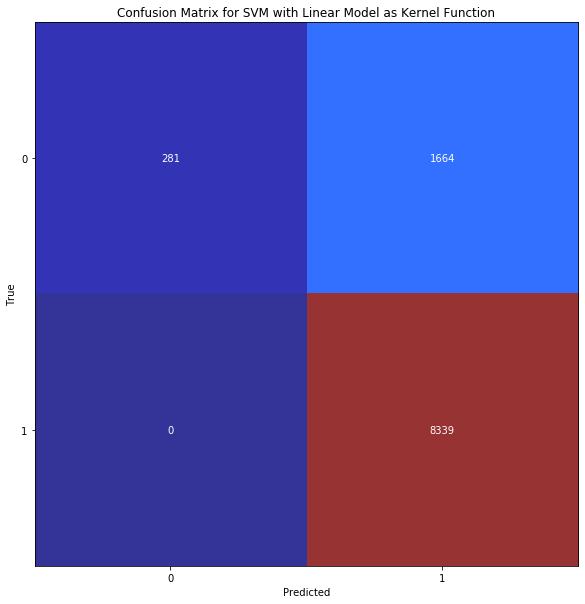

In [110]:
#Linear model used in labs
svm_lm = linear_model.SGDClassifier(loss='hinge', random_state = 0) 
svm_lm.fit(NORM_corpus_train_TNmix_chi2_BEST, goal_train)
pred_svm_lm = svm_lm.predict(NORM_corpus_test_TNmix_chi2_BEST) 
print('Accuracy rate:', np.round(metrics.accuracy_score(goal_test, pred_svm_lm), 3), '\n')
print('confusion matrix: \n', confusion_matrix(pred_svm_lm,goal_test), '\n')
print('classification report: \n',metrics.classification_report(goal_test,pred_svm_lm), '\n')
confusion_matrix_plot(pred_svm_lm, goal_test, 'Linear')

Accuracy rate: 0.856 

confusion matrix: 
 Predicted:    0     1    All
True:                       
0           488  1457   1945
1            24  8315   8339
All         512  9772  10284 

classification report: 
               precision    recall  f1-score   support

           0       0.95      0.25      0.40      1945
           1       0.85      1.00      0.92      8339

    accuracy                           0.86     10284
   macro avg       0.90      0.62      0.66     10284
weighted avg       0.87      0.86      0.82     10284
 



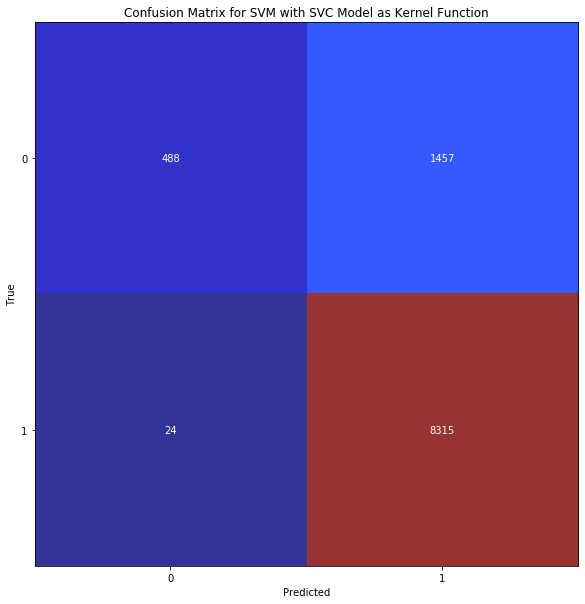

In [109]:
#Linear SVC model
svclassifier = SVC(kernel='linear')
svclassifier.fit(NORM_corpus_train_TNmix_chi2_BEST, goal_train)
pred_svc = svclassifier.predict(NORM_corpus_test_TNmix_chi2_BEST)
print('Accuracy rate:', np.round(metrics.accuracy_score(goal_test, pred_svc), 3), '\n')
print('confusion matrix: \n', confusion_matrix(pred_svc,goal_test), '\n')
print('classification report: \n', metrics.classification_report(goal_test,pred_svc), '\n')
confusion_matrix_plot(pred_svc, goal_test, 'SVC')

best gamma: scale 
 best degree: 2 

Accuracy rate: 0.861 

confusion matrix: 
 Predicted:    0     1    All
True:                       
0           534  1411   1945
1            20  8319   8339
All         554  9730  10284 

classification report: 
               precision    recall  f1-score   support

           0       0.96      0.27      0.43      1945
           1       0.85      1.00      0.92      8339

    accuracy                           0.86     10284
   macro avg       0.91      0.64      0.67     10284
weighted avg       0.88      0.86      0.83     10284
 



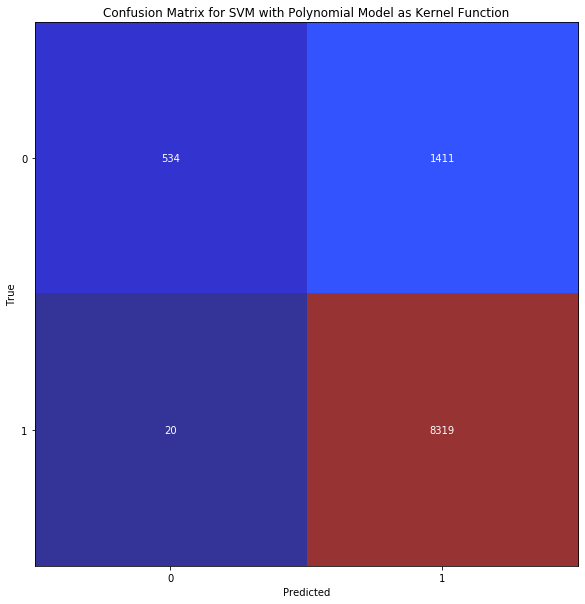

In [108]:
#Polynomial model
gamma_s = [0.8, 1, 1.2, 'scale']
degree = [2, 3, 4]
accuracy_rate_poly = []
degree_poly = []
for g in gamma_s:
    for d in degree:
        svm_poly = SVC(kernel='poly', degree=d, gamma=g)
        svm_poly.fit(NORM_corpus_train_TNmix_chi2_BEST, goal_train)
        pred_svm_poly = svm_poly.predict(NORM_corpus_test_TNmix_chi2_BEST)
        accuracy_rate_poly.append(np.round(metrics.accuracy_score(goal_test, pred_svm_poly), 3))

poly_best_gamma = gamma_s[int(accuracy_rate_poly.index(max(accuracy_rate_poly))/3)]
poly_best_degree = degree[accuracy_rate_poly.index(max(accuracy_rate_poly))%3]
svm_poly = SVC(kernel='poly', degree=poly_best_degree, gamma=poly_best_gamma)
svm_poly.fit(NORM_corpus_train_TNmix_chi2_BEST, goal_train)
pred_svm_poly = svm_poly.predict(NORM_corpus_test_TNmix_chi2_BEST)

print('best gamma:', poly_best_gamma, '\n', 'best degree:', poly_best_degree, '\n')
print('Accuracy rate:', np.round(metrics.accuracy_score(goal_test, pred_svm_poly), 3), '\n')
print('confusion matrix: \n', confusion_matrix(pred_svm_poly, goal_test), '\n')
print('classification report: \n', metrics.classification_report(goal_test,pred_svm_poly), '\n')
confusion_matrix_plot(pred_svm_poly, goal_test, 'Polynomial')

best gamma: 1.0 

Accuracy rate: 0.87 

confusion matrix: 
 Predicted:    0     1    All
True:                       
0           759  1186   1945
1           156  8183   8339
All         915  9369  10284 

classification report: 
               precision    recall  f1-score   support

           0       0.83      0.39      0.53      1945
           1       0.87      0.98      0.92      8339

    accuracy                           0.87     10284
   macro avg       0.85      0.69      0.73     10284
weighted avg       0.87      0.87      0.85     10284
 



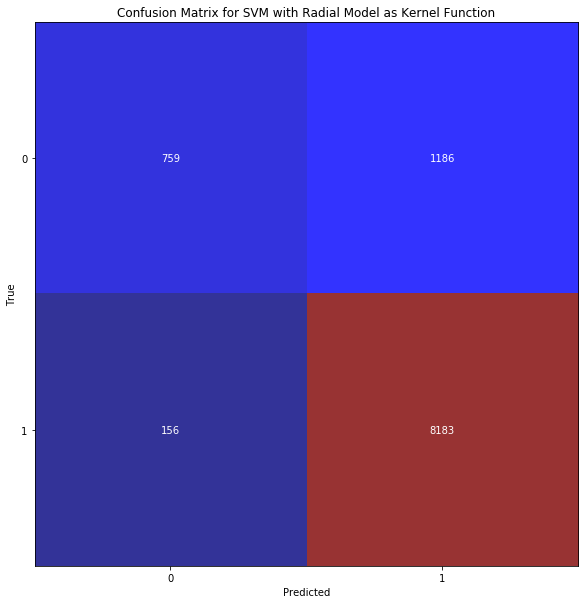

In [107]:
#Radial Model
gamma = [np.round(0.2*x, 2) for x in range(1, 8)] + [0.01] + ['scale', 'auto']
accuracy_rate_rbf = []
for g in gamma:
    svm_rbf = SVC(kernel='rbf', gamma=g)
    svm_rbf.fit(NORM_corpus_train_TNmix_chi2_BEST, goal_train)
    pred_svm_rbf = svm_rbf.predict(NORM_corpus_test_TNmix_chi2_BEST)
    accuracy_rate_rbf.append(np.round(metrics.accuracy_score(goal_test, pred_svm_rbf), 3))

rbf_best_gamma = gamma[accuracy_rate_rbf.index(max(accuracy_rate_rbf))]
svm_rbf = SVC(kernel='rbf', gamma=rbf_best_gamma)
svm_rbf.fit(NORM_corpus_train_TNmix_chi2_BEST, goal_train)
pred_svm_rbf = svm_rbf.predict(NORM_corpus_test_TNmix_chi2_BEST)

print('best gamma:', rbf_best_gamma, '\n')
print('Accuracy rate:', np.round(metrics.accuracy_score(goal_test, pred_svm_rbf), 3), '\n')
print('confusion matrix: \n', confusion_matrix(pred_svm_rbf, goal_test), '\n')
print('classification report: \n', metrics.classification_report(goal_test,pred_svm_rbf), '\n')
confusion_matrix_plot(pred_svm_rbf, goal_test, 'Radial')

best gamma: 1.2 

Accuracy rate: 0.859 

confusion matrix: 
 Predicted:    0     1    All
True:                       
0           538  1407   1945
1            43  8296   8339
All         581  9703  10284
classification report: 
               precision    recall  f1-score   support

           0       0.93      0.28      0.43      1945
           1       0.85      0.99      0.92      8339

    accuracy                           0.86     10284
   macro avg       0.89      0.64      0.67     10284
weighted avg       0.87      0.86      0.83     10284
 



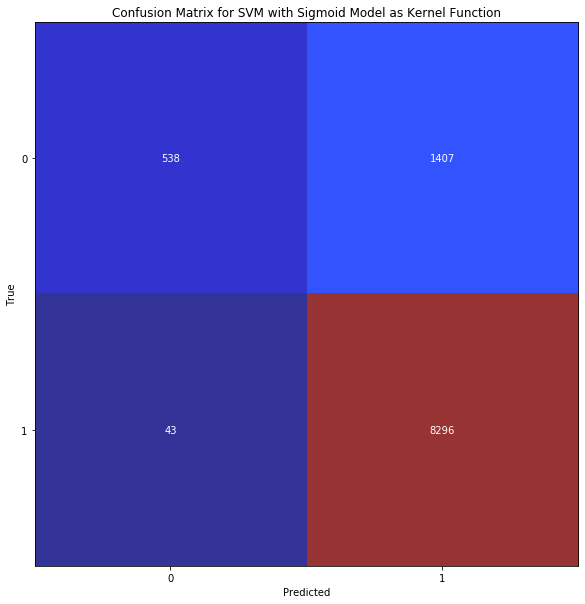

In [104]:
#Sigmoid Model
accuracy_rate_sig = []
for g in gamma_s:
    svm_sig = SVC(kernel='sigmoid', gamma=g)
    svm_sig.fit(NORM_corpus_train_TNmix_chi2_BEST, goal_train)
    pred_svm_sig = svm_sig.predict(NORM_corpus_test_TNmix_chi2_BEST)
    accuracy_rate_sig.append(np.round(metrics.accuracy_score(goal_test, pred_svm_sig), 3))

sig_best_gamma = gamma_s[accuracy_rate_sig.index(max(accuracy_rate_sig))]
svm_sig = SVC(kernel='sigmoid', gamma=sig_best_gamma)
svm_sig.fit(NORM_corpus_train_TNmix_chi2_BEST, goal_train)
pred_svm_sig = svm_sig.predict(NORM_corpus_test_TNmix_chi2_BEST)

print('best gamma:', sig_best_gamma, '\n')
print('Accuracy rate:', np.round(metrics.accuracy_score(goal_test, pred_svm_sig), 3), '\n')
print('confusion matrix: \n', confusion_matrix(pred_svm_sig, goal_test))
print('classification report: \n', metrics.classification_report(goal_test,pred_svm_sig), '\n')
confusion_matrix_plot(pred_svm_sig, goal_test, 'Sigmoid')

## Word Cloud for Most Frequent Words in Positive and Negative Rating Review Comments

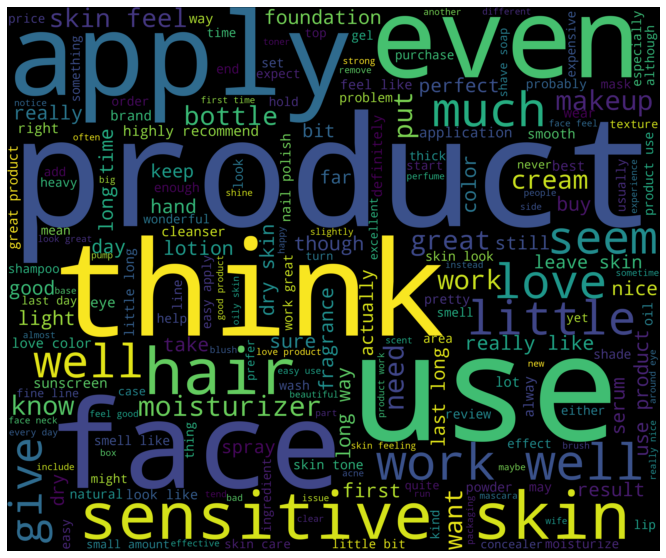

In [64]:
words_positive = ' '.join(df[df['label']==1]['reviewText'])
wordcloud = WordCloud(background_color='black', 
                      height = 2500, width = 3000).generate(words_positive)
plt.figure(figsize=(30,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

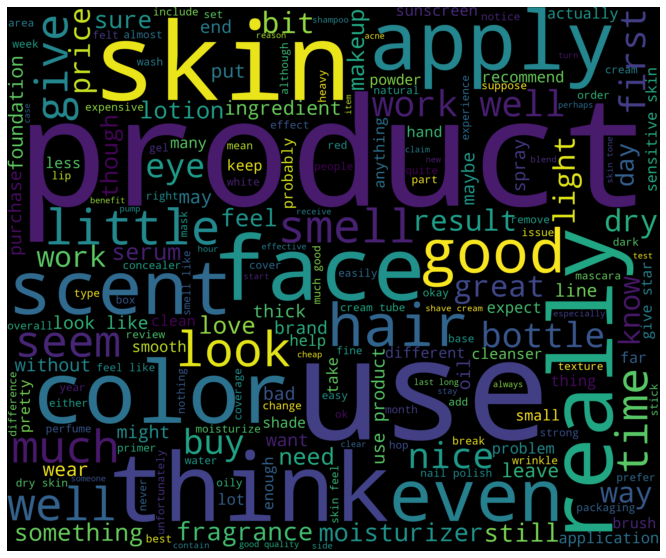

In [63]:
words_negative = ' '.join(df[df['label']==0]['reviewText'])
wordcloud = WordCloud(background_color='black', 
                      height = 2500, width = 3000).generate(words_negative)
plt.figure(figsize=(30,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Below are other alternative codes used along the process.**

In [ ]:
#Colab Setup
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
#read .gz file
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('Luxury_Beauty_5.json.gz')

In [ ]:
kf = KFold(n_splits=5)
for train, test in kf.split(corpus, goal):
    X_train, X_test = corpus[train], goal[test]
    Y_train, Y_test = corpus[train], goal[test]

In [ ]:
#Text Classification
from sklearn.naive_bayes import MultinomialNB
NB_tc = MultinomialNB(alpha=0.1)
NB_tc.fit(NORM_corpus_train_bow_chi2_BEST, corpus_train.target)
predicted_nb_chi2_best = NB_tc.predict(NORM_corpus_test_bow_chi2_BEST)
cm_chi2_best = metrics.confusion_matrix(corpus_test.target, predicted_nb_chi2_best)
print("Confusion matrix: \n", pd.DataFrame(data = cm_chi2_best , 
                                           columns = corpus_train.target_names,
                                           index = corpus_train.target_names),"\n")
print("Accuracy rate: ", metrics.accuracy_score(corpus_test.target, predicted_nb_chi2_best),"\n") 

def NB_find_best_alpha(i):

    NB_tc = MultinomialNB(alpha=i)
    NB_tc.fit(NORM_corpus_train_bow_chi2_BEST, corpus_train.target)
    predicted_nb_chi2_best = NB_tc.predict(NORM_corpus_test_bow_chi2_BEST)
    cm_chi2_best = metrics.confusion_matrix(corpus_test.target, predicted_nb_chi2_best)
    #print("Confusion matrix: \n", pd.DataFrame(data = cm_chi2_best , 
    #                                           columns = corpus_train.target_names,
    #                                           index = corpus_train.target_names),"\n")
    #print("Accuracy rate: ", metrics.accuracy_score(corpus_test.target, predicted_nb_chi2_best),"\n") 
    dict_alpha[i] = metrics.accuracy_score(corpus_test.target, predicted_nb_chi2_best)
    
    return dict_alpha

dict_alpha = {}
lst = [x * 0.1 for x in range(0, 10)]
for i in lst:
    NB_find_best_alpha(i)

dict_alpha
#best alpha is 0.2